# Проект по анализу оттока и кластеризации пользователей для фитнес-клуба

## Небоходимо спрогнозировать вероятность оттока позователей на основе исторических данных - анкет клиентов, а также проести кластеризацию клиентов на группы.  


[1. Загрузка необходимых библиотек ](#dependancy_download)  
[2. Загрузка и знакомство с данными](#data_download)  
[3. Предобработка данных](#data_preprocessing)  
[4. Моделирование оттока клиентов](#modeling)  
[5. Кластеризация клиентов](#clustering)  
[6. Выводы и рекоммендации](#conclusions)  

<a id='dependancy_download'></a>
### 1. Загрузка необходимых библиотек 

In [185]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn import metrics

import itertools
from itertools import combinations


<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



<a id='data_download'></a>
### 2. Загрузка и знакомство с данными

In [4]:
path_local = '/Users/juliagrobman/Downloads/gym_churn.csv'
path_global = '/datasets/gym_churn.csv'

if os.path.exists(path_local):
    data = pd.read_csv(path_local)
elif os.path.exists(path_global):
    data = pd.read_csv(path_global)
else:
    print('ERROR WITH DATA PATH')


In [5]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

#### Датасет содержит 4000 строк, столбец 'Churn' содержит целевой признак  
#### Пропусков нет, тип данных соотвествует содержанию

In [7]:
# Приведем столбцы к нижнему регистру
data.columns = data.columns.str.lower()

In [8]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [9]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [11]:
stayed = data.query('churn==0')
quit = data.query('churn==1')

In [12]:
data.groupby('churn', as_index=False).mean()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Видим, что некоторые средние значения признаков обеих группах не отличаются или отличаются несильно: пол, наличие контактного телефона, проживание или работа в районе, где находится финтес-центр, другие же отличаются очень заметно: длительность действующего абонемента, факт посещения групповых занятий и тп

In [35]:
# Построим распределения признаков для тех, кто ушел, и тех, кто остался
for col in data.drop(['churn','gender','phone'], axis=1).columns:
    fig = px.histogram(data, x = col, color='churn',\
        title = 'Histogram of {}'.format(col))
    

    fig.show()

Распределение признаков похоже для уходящих и остающихся клиентов, обращают на себя внимание выбросы в признаках "avg_class_frequency_current_month", "lifetime","avg_class_frequency_current_month".  
  
Посмотрим подробнее в разделе про педобработку данных.

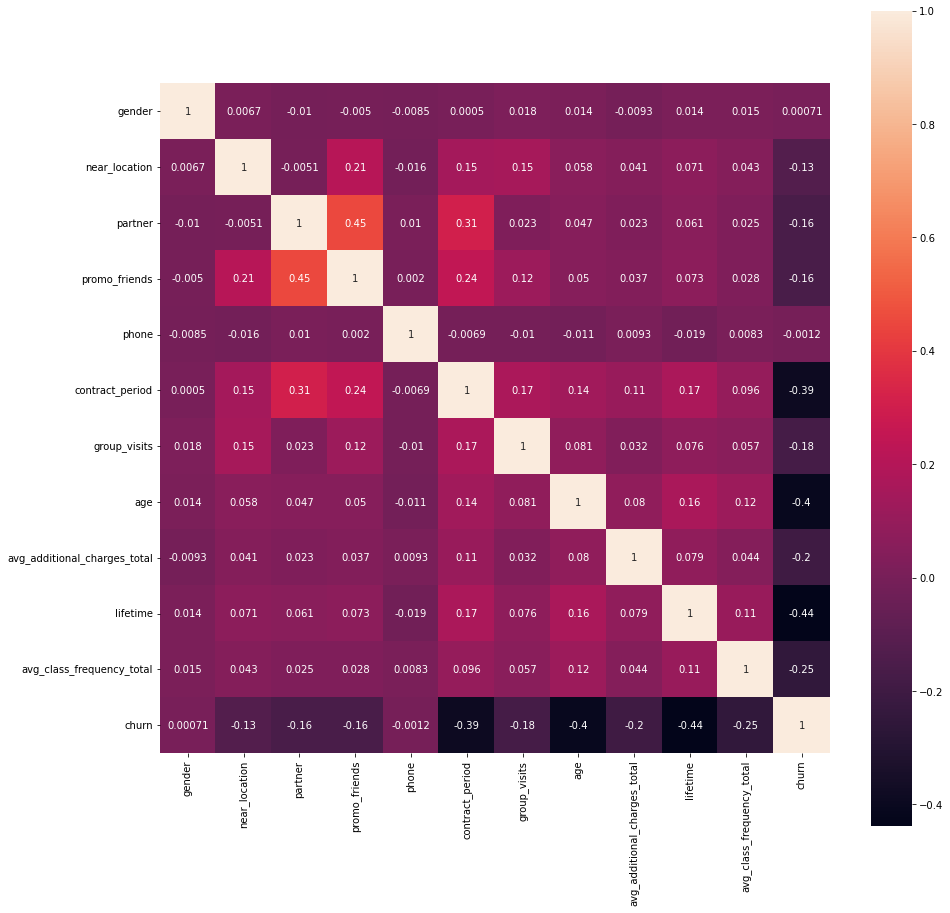

In [39]:
# Построим матрицу корреляций
cm = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cm, square=True, annot=True)
plt.title = 'Матрица корреляции'
plt.show()

По хитмапу видим, что есть сильно скоррелированные признаки:   
* 'avg_class_frequency_current_month', 'avg_class_fequency_total'  
* 'contract_period' , 'month_to_end_contract'  

удалим один из признаков в каждой паре

In [38]:
data = data.drop(['avg_class_frequency_current_month','month_to_end_contract'], axis=1)

<a id='data_preprocessing'></a>
### 3. Предобработка данных

In [48]:
#Проверим данные на выбросы:
# создадим список цисленных столбцов
numerical = ['age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

In [50]:
# построим boxplot
for col in numerical:
    fig = px.box(data, y=col, title='Распределение {}'.format(col))
    fig.show()

In [55]:
# Видим, что в данных присутствут выбросы, удалим их:
data = data.query('(\
    age <= 37 ) \
    and (age >=21) \
    and (avg_additional_charges_total <=416) \
    and (lifetime <=11)\
    and (avg_class_frequency_total <=4.565)')

In [57]:
data.lifetime.max(), data.age.max()

(11, 37)

Произвели исследование и предобработку данных, удалили выбросы высококоррелированные столбцы, данные готовы для моделирования

<a id='modeling'></a>
### 4. Моделирование оттока клиентов

In [145]:
# обработаем данные
num_transformer = Pipeline([('scaler',StandardScaler())
])
cat_transormer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [146]:
num_features = numerical
cat_features = ['gender','near_location','partner','promo_friends','phone', 'contract_period','group_visits']

In [147]:
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transormer, cat_features)
])

In [148]:
# создадим pipeline логистической регрессии
pipe_lr = Pipeline([('preprocess',preprocessor),
('clf', LogisticRegression(random_state=123)) ])

# создадим pipeline случайного леса
pipe_rf = Pipeline([('preprocess',preprocessor),
('clf', RandomForestClassifier(random_state=123))])

In [149]:
#добвим параметры для моделей

grid_params_lr = [{
    'clf__penalty' : ['l1','l2'],
    'clf__C' :  [1.0,0.5],
    'clf__solver' : ['liblinear']

}]

grid_params_rf = [{
    'clf__criterion' : ['gini','entropy'],
    'clf__max_depth' : np.arange(10,50,5),
    'clf__n_estimators': np.arange(20,200,10)
}]


In [150]:
# Создадим GridSearch
LR = GridSearchCV(estimator=pipe_lr,
param_grid=grid_params_lr,
scoring = 'f1', cv=5)

RF = GridSearchCV(estimator = pipe_rf, 
param_grid = grid_params_rf,
scoring='f1', cv=5)

In [151]:
grids = [LR, RF]
grid_dict = {0: 'LogisticRegression', 1:'Random Forest'}

In [152]:
#разделим выборки
features = data.drop('churn', axis=1)
target = data['churn']
features_train, features_test, target_train, target_test = train_test_split \
    (features, target, test_size=0.2, random_state=123)


In [186]:

print('Performing model optimizations...')
best_f1 = 0
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(features_train, target_train)
    print('Best params are : %s' % gs.best_params_)
# Best training data accuracy
    print('Best f1_score: %.3f' % gs.best_score_)
# Predict on test data with best params
    y_pred = gs.predict(features_test)
# Test data accuracy of model with best params
    f1 = metrics.f1_score(target_test, y_pred)
    print('Test set f1 score for best params: {:.2f}'.format(f1))
# Track best (highest test accuracy) model
    if f1 > best_f1:
        best_f1 = f1
        best_gs = gs
        best_clf = idx

print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])
        


Performing model optimizations...

Estimator: LogisticRegression
Best params are : {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best f1_score: 0.810
Test set f1 score for best params: 0.82

Estimator: Random Forest
Best params are : {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 90}
Best f1_score: 0.794
Test set f1 score for best params: 0.83

Classifier with best test set f1: Random Forest


In [187]:
reg = LogisticRegression()
reg.fit(features_train, target_train)
reg_pred = reg.predict(features_test)
reg_f1 = metrics.f1_score(target_test, reg_pred)
reg_pres = metrics.precision_score(target_test, reg_pred)
reg_recall = metrics.recall_score(target_test,reg_pred)
reg_acc = metrics.accuracy_score(target_test, reg_pred)



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [188]:
forest = RandomForestClassifier()
forest.fit(features_train, target_train)
forest_pred = forest.predict(features_test)
forest_f1 = metrics.f1_score(target_test, forest_pred)
forest_pres = metrics.precision_score(target_test, forest_pred)
forest_recall = metrics.recall_score(target_test,forest_pred)
forest_acc = metrics.accuracy_score(target_test, forest_pred)

In [191]:
metrics = ['f1', 'percision','recall', 'accuracu']
LR_metrics = [reg_f1, reg_pres, reg_recall,reg_acc]
FOR_metrics = [forest_f1, forest_pres, forest_recall, forest_acc]

In [192]:
data_cumm = pd.DataFrame({'metircs':metrics, 'LR':LR_metrics, 'Forest':FOR_metrics})

In [193]:
data_cumm.sort_values

,metircs,LR,Forest
0,f1,0.812652,0.825000
1,percision,0.814634,0.850515
2,recall,0.810680,0.800971
3,accuracu,0.896921,0.906292


### Видим,  что модель Random forest лучше показала себя, демонстрируюя очень высокие метрики качества

<a id='clustering'></a>
### 5. Кластеризация клиентов

In [ ]:
# проведем стандартизацию данных
sc = StandardScaler()
features_sc = fit_transform(features)
linked = linkage(featurs_sc, method = 'ward')

# построим дендрограмму
fig = ff.create_dengrogram(linked)
fig.update_layout(width=800, height=500)
fig.show()

In [ ]:
# проведем кластеризацию алгоритмом KMeans
km = KMeans(n_clusters=5, random_state=123)
labels = km.fit_predict(features)

data['cluster_km'] = labels

data.groupby('cluster_km').mean()

In [ ]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsiz=(5,5))
    sns.scatterplot(
        df[x_name], df[y_name], hue = df[cluster_name], palette='Paired'
    )

<a id='conclusions'></a>
### 6. Выводы и рекоммендации